In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab06.ipynb")

# Lab 6: Linear Regression

In this lab, you will review the details of linear regresison. In particular:

* Matrix formulation and solution to Ordinary Least Squares (OLS).
* `sns.lmplot` as a quick visual for Simple Linear Regression (SLR).
* `scikit-learn`, or `sklearn` for short, a real world data science tool that is more robust and flexible than analytical or `scipy.optimize` solutions. 

You will also practice interpreting residual plots (vs. fitted values) and the Multiple $R^2$ metric used in Multiple Linear Regression.


**The on-time deadline is Tuesday, Feburary 28th, 11:59pm. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted.**

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** This video is recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but content is identical.

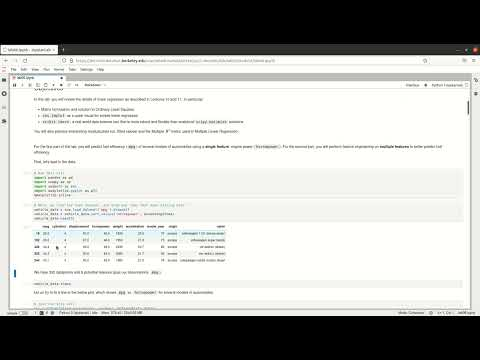

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("IkkhAr3e19Q", list = 'PLQCcNQgUcDfpuwnASdUyvQky51ZcYMWSy', listType = 'playlist')


### Collaboration Policy

Data science is a collaborative activity. While you may talk to others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following cell:

**Collaborators**: *List names here*

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Data Loading

For the first part of this lab, you will predict fuel efficiency (`mpg`) of several models of automobiles using a **single feature**: engine power (`horsepower`). For the second part, you will perform feature engineering on **multiple features** to better predict fuel efficiency.

First, let's load in the data.

In [4]:
# Here, we load the fuel dataset, and drop any rows that have missing data.
vehicle_data = sns.load_dataset('mpg').dropna()
vehicle_data = vehicle_data.sort_values('horsepower', ascending=True)
vehicle_data.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [6]:
vehicle_data.shape

(392, 9)

We have 392 datapoints and 8 potential features (plus our observations, `mpg`).

Let us try to fit a line to the below plot, which shows `mpg` vs. `horsepower` for several models of automobiles.

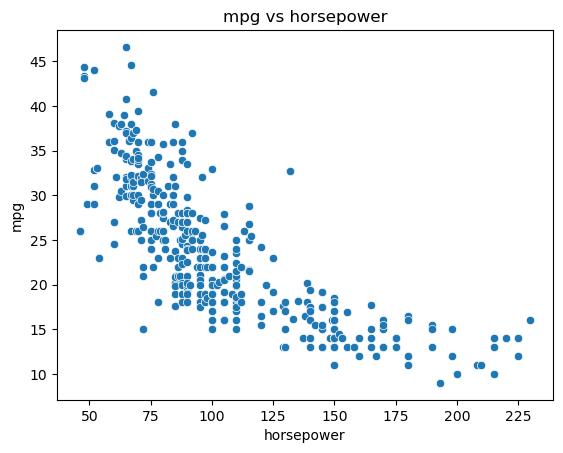

In [7]:
# Run this cell to visualize the data. 
sns.scatterplot(x = 'horsepower', y = 'mpg', data = vehicle_data);
plt.title("mpg vs horsepower");

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1: Ordinary Least Squares

Instead of using the SLR formulation, in this lab we will practice linear algebra with Ordinary Least Squares. Recall that the Simple Linear Regression model is written as follows:

$$\hat{y} = \theta_0 + \theta_1 x$$

We now use $\theta = [\theta_0, \theta_1]$ so that the formulation more closely matches our multiple linear regression model:

$$\hat{y} = \theta_0 + \theta_1 x_1 + \dots + \theta_p x_p$$

We can rewrite our multiple linear regression model using matrix notation. Let $\mathbb{Y}$ be a vector of all $n$ observations in our sample. Then our prediction vector $\hat{\mathbb{Y}}$ is:

$$\Large \hat{\mathbb{Y}} = \mathbb{X} \theta$$

where $\mathbb{X} \in \mathbb{R}^{n\times p}$ is the **design matrix** representing the $p$ features for all $n$ datapoints in our sample.

Note that for our SLR model, $p = 1$ and therefore the matrix notation seems rather silly. Nevertheless it is valuable to start small and build on our intuition.

<br><br>

---

### Question 1a: Construct $\mathbb{X}$ with an intercept term

Because we have an intercept term $\theta_0$ in our parameter vector $\theta$, we need to augment our design matrix $\mathbb{X}$ with one all-ones column and hence the dimensionality of the design matrix after augmentation will be:

$$ \Large \mathbb{X} \in \mathbb{R}^{n \times (p + 1)}$$

Therefore, the resulting matrix expression $\hat{\mathbb{Y}} = \mathbb{X} \theta$ represents $n$ linear equations, where equation $i$ is $\hat{y_i} = \theta_0 \cdot 1 + \theta_1 \cdot x_{i1} + \dots + \theta_p x_{ip}$ where $x_{ij}$ is the $j^{th}$ feature of the $i^{th}$ datapoint. The constant all-ones column of $\mathbb{X}$ is sometimes called the bias feature; $\theta_0$ is frequently called the **bias or intercept term**.

<br/>

Below, implement `add_intercept`, which computes a design matrix such that the first (left-most) column is all ones. The function has two lines: you are responsible for constructing the all-ones column `bias_feature` using the `np.ones` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones)). This is then piped into a call to `np.concatenate` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)), which we've implemented for you.

Note: `bias_feature` should be a matrix of dimension `(n,1)`, not a vector of dimension `(n,)`.


In [10]:
def add_intercept(X):
    """
    Return X with a bias feature.
    
    Parameters
    -----------
    X: a 2D dataframe of p numeric features
    (may also be a 2D numpy array) of shape n x p
    
    Returns
    -----------
    A 2D matrix of shape n x (p + 1), where the leftmost
    column is a column vector of 1's
    """
    n, p = X.shape
    bias_feature = np.ones(shape = (n, 1))
    return np.concatenate([bias_feature, X], axis=1)

# Note the [[ ]] brackets below: the argument needs to be
# a matrix (DataFrame), as opposed to a single array (Series).
X = add_intercept(vehicle_data[['horsepower']])
X.shape

(392, 2)

In [11]:
grader.check("q1a")

q1a results: All test cases passed!

<br><br>

---
### Question 1b: Define the OLS Model

The predictions for all $n$ points in our data are (note $\theta = [\theta_0, \theta_1, \dots, \theta_p]$) :
$$ \Large \hat{\mathbb{Y}} = \mathbb{X}\theta $$

Below, implement the `linear_model` function to evaluate this product.

**Hint**: You can use `np.dot` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)), `pd.DataFrame.dot` ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html)), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `numpy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!



In [18]:
def linear_model(thetas, X):
    """
    Return the linear combination of thetas and features as defined above.
    
    Parameters
    -----------
    thetas: a 1D vector representing the parameters of our model ([theta0, theta1, ...])
    X: a 2D dataframe of numeric features (may also be a 2D numpy array)
    
    Returns
    -----------
    A 1D vector representing the linear combination of thetas and features as defined above.
    """
    return np.dot(X, thetas)

In [19]:
grader.check("q1b")

q1b results: All test cases passed!

<br><br>

---

### Question 1c: Least Squares Estimate, Analytically

Recall from lecture that Ordinary Least Squares is when we fit a linear model with mean squared error, which is equivalent to the following optimization problem:

$$\Large \min_{\theta} ||\Bbb{X}\theta - \Bbb{Y}||^2$$

We showed in Lecture that the optimal estimate $\hat{\theta}$ when $X^TX$ is invertible is given by the equation:

$$ \Large \hat{\theta} = (\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$$

Below, implement the analytic solution to $\hat{\theta}$ using `np.linalg.inv` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to compute the inverse of $\Bbb{X}^T\Bbb{X}$.

Reminder: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T)).

Note: You can also consider using `np.linalg.solve` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)) instead of `np.linalg.inv` because it is more robust (more on StackOverflow [here](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li)). 


In [22]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our
    least squares problem
    
    Parameters
    -----------
    X: a 2D dataframe (or numpy array) of numeric features
    y: a 1D vector of outputs
    
    Returns
    -----------
    The estimate for theta (a 1D vector) computed using the
    equation mentioned above.
    """
    XTX = X.T.dot(X)
    XTy = X.T.dot(y)
    return np.linalg.inv(XTX).dot(XTy)

Y = vehicle_data['mpg']
analytical_thetas = get_analytical_sol(X, Y)
analytical_thetas

array([39.93586102, -0.15784473])

In [23]:
grader.check("q1c")

q1c results: All test cases passed!

<br/><br/>

Now, let's analyze our model's performance. Your task will be to interpret the model's performance using the two visualizations and one performance metric we've implemented below.

First, we run `sns.lmplot`, which will both provide a scatterplot of `mpg` vs `horsepower` and display the least-squares line of best fit. (If you'd like to verify the OLS fit you found above is the same line found through Seaborn, change `include_OLS` to `True`.)

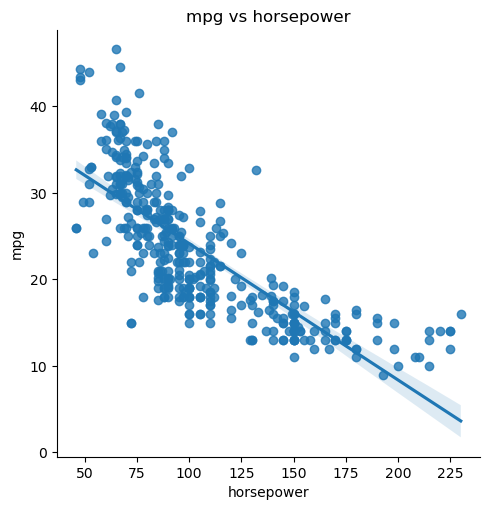

In [24]:
include_OLS = False # Change this flag to visualize OLS fit

sns.lmplot(x = 'horsepower', y = 'mpg', data = vehicle_data);
predicted_mpg_hp_only = linear_model(analytical_thetas, X)
if include_OLS:
    # if flag is on, add OLS fit as a dotted red line
    plt.plot(vehicle_data['horsepower'], predicted_mpg_hp_only, 'r--')
plt.title("mpg vs horsepower");

Next, we **plot the residuals.** While in Simple Linear Regression we have the option to plot residuals vs. the single input feature, in Multiple Linear Regression we often plot residuals vs fitted values $\hat{\mathbb{Y}}$. In this lab, we opt for the latter.

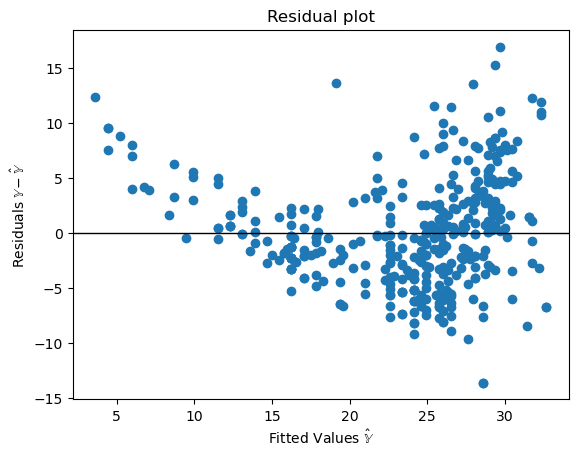

In [25]:
plt.scatter(predicted_mpg_hp_only, Y - predicted_mpg_hp_only)
plt.axhline(0, c='black', linewidth=1)
plt.xlabel(r'Fitted Values $\hat{\mathbb{Y}}$')
plt.ylabel(r'Residuals $\mathbb{Y} - \hat{\mathbb{Y}}$');
plt.title("Residual plot");

Finally, we compute the the **correlation r** and **Multiple $R^2$** metric. As described in Lecture 12 ([link](https://docs.google.com/presentation/d/1f8Qoj1SPft2jHrusP83TGhJoz3dHJnp4fPBn5j9veMY/edit#slide=id.g1163459c7f0_0_86)),

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

$R^2$  can be used
in the multiple regression setting, whereas $r$ (the correlation coefficient) is restricted to SLR since it depends on a single input feature.  In SLR, $r^{2}$ and Multiple $R^{2}$ are
equivalent; the proof is left to you.

In [26]:
r_hp_only = np.corrcoef(X[:, 1], Y)[0, 1]
r2_hp_only = r_hp_only ** 2
R2_hp_only = np.var(predicted_mpg_hp_only) / np.var(Y)

print('Correlation, r, using only horsepower: ', r_hp_only)
print('Correlation squared, r^2, using only horsepower: ', r2_hp_only)
print('Multiple R^2 using only horsepower: ', r2_hp_only)

Correlation, r, using only horsepower:  -0.7784267838977761
Correlation squared, r^2, using only horsepower:  0.605948257889435
Multiple R^2 using only horsepower:  0.605948257889435


<br><br>

---
### Question 1d

In the cell below, comment on the above visualization and performance metrics, and whether `horsepower` and `mpg` have a good linear fit.


Our linear model seems inappropriate because there is clear curvature in the redidual plot. One thing we expect in a fresidual plot is uniform scatter, and since we don't have that, we have to take a look at transofrming or changing our input features to make the residual plot more uniformly scattered.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2: Transform a Single Feature

The Tukey-Mosteller Bulge Diagram tells us to transform our $\mathbb{X}$ or $\mathbb{Y}$ to find a linear fit.

Let's consider the following linear model:

$$\text{predicted mpg} = \theta_0 + \theta_1 \sqrt{\text{horsepower}}$$

<br><br>

---
### Question 2a

In the cell below, explain why we use the term "linear" to describe the model above, even though it incorporates a square-root of horsepower  as a feature.


The model is linear is because it is linear in term "linear" of the model parameters, which is what we mean by a "linear model".

### Introduction to `sklearn`

Another way to fit a linear regression model is to use `scikit-learn`, an industry standard package for machine learning applications. Because it is application-specific, `sklearn` is often faster and more robust than the analytical or `scipy`-based computation methods we've used thus far. Note that `scikit-learn` and `sklearn` refers to the same package, but it can only be imported under the name `sklearn`. We will use these two names interchangeably in this class.

To use `sklearn`:

1. Create an `sklearn` object.
1. `fit` the object to data.
1. Analyze fit or call `predict`.

##### **1. Create object.** 

We first create a `LinearRegression` object. Here's the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Note that by default, the object will include an intercept term when fitting.

Here, `model` is like a "blank slate" for a linear model.

In [27]:
# 1. Run this cell to initialize an sklearn LinearRegression object.
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

##### **2. `fit` the object to data.** 

Now, we need to tell `model` to "fit" itself to the data. Essentially, this is doing exactly what you did in the previous part of this lab (creating a risk function and finding the parameters that minimize that risk).

**Note**: `X` needs to be a matrix (or `DataFrame`), as opposed to a single array (or `Series`). This is because `sklearn.linear_model` is robust enough to be used for multiple regression, which we will look at later this lab.

In [28]:
# 2. Run this cell to add sqrt(hp) column for each car in the dataset.
vehicle_data['sqrt(hp)'] = np.sqrt(vehicle_data['horsepower'])
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp)
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203


In [29]:
# 2. Run this cell to fit the model to the data.
model.fit(X = vehicle_data[['sqrt(hp)']], y = vehicle_data['mpg'])

LinearRegression()

##### **3. Analyze fit.** 

Now that the model exists, we can look at the $\hat{\theta}_0$ and $\hat{\theta}_1$ values it found, which are given in the attributes `intercept` and `coef`, respectively.

In [30]:
model.intercept_

58.70517203721748

In [31]:
model.coef_

array([-3.50352375])

Call `predict`.** To use the `sklearn` linear regression model to make predictions, you can use the `model.predict` method.

Below, we find the estimated `mpg` for a single datapoint with a `sqrt(hp)` of 6.78 (i.e., horsepower 46).

Note that unlike the linear algebra approach, we do not need to manually add an intercept term, because our `model` (which was created with `fit_intercept=True`) will auto-add one.

**Note:** You may recieve a user warnings about missing feature names. This is due to the fact that we fitted on the feature DataFrame `vehicle_data[['sqrt(hp)']]` with feature names `"sqrt(hp)"` but only pass in a simple 2D arrays for prediction. To avoid this, we can convert our 2D array into a DataFrame with the matching feature name.

In [32]:
# Needs to be a 2D array since the X in step 2 was 2-dimensional.
single_datapoint = [[6.78]]
# Uncomment the following to see the result of predicting on a DataFrame instead of 2D array.
#single_datapoint = pd.DataFrame([[6.78]], columns = ['sqrt(hp)']) # 
model.predict(single_datapoint) 

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([34.95128104])

<br><br>

---

### Question 2b

Using the model defined above, set `predicted_mpg` to the predicted `mpg` for the data below. Running the cell will then compute the multiple $R^2$ value and create a linear regression plot for this new square root feature, overlaid on the original least squares estimate (used in Question 1c).

Multiple R^2 using sqrt(hp):  0.6437035832706473


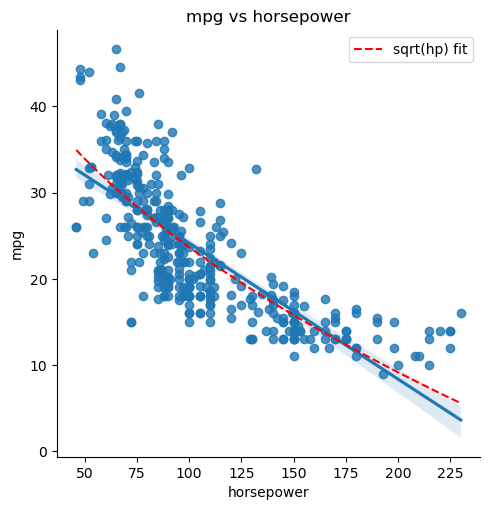

In [33]:
predicted_mpg_hp_sqrt = model.predict(vehicle_data[['sqrt(hp)']]) # SOLUTION

# Do not modify below this line.
r2_hp_sqrt = np.var(predicted_mpg_hp_sqrt) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)

sns.lmplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt,
         color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.title("mpg vs horsepower")
plt.legend();

The visualization shows a slight improvement, but note that the underlying pattern is parabolic--suggesting that perhaps we should try a quadratic feature. Next, we use the power of multiple linear regression to **add an additional feature.**

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Add an Additional Feature

For the second part of this lab, we move from SLR to multiple linear regression.

Until now, we have established relationships between one independent explanatory variable and one response variable. However, with real-world problems you will often want to use **multiple features** to model and predict a response variable. Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data.

We can consider including functions of existing features as **new features** to help improve the predictive power of our model. (This is something we will discuss in further detail in the Feature Engineering lecture.)

The cell below adds a column which contains the square of the horsepower for each car in the dataset.

In [34]:
# Run this cell to add a column of horsepower squared, no further action needed.
vehicle_data['hp^2'] = vehicle_data['horsepower'] ** 2
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp),hp^2
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330,2116.0
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330,2116.0
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203,2304.0
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203,2304.0
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203,2304.0


<br><br>

---
## Question 3

### Question 3a

Using sklearn's `LinearRegression`, create and fit a model that tries to predict `mpg` from `horsepower` AND `hp^2` using the DataFrame `vehicle_data`. Name your model `model_multi`.

**Hint**: It should follow similar format as Question 2.
**Note**: You must create a new model again using LinearRegression(), otherwise the old model will be overwritten. If you are unsure why this happen, please review [object oriented programing](https://cs61a.org/study-guide/objects/) from CS61A.

In [38]:
model_multi = LinearRegression() # By default, fit_intercept=True
model_multi.fit(X = vehicle_data[['horsepower', 'hp^2']], y = vehicle_data['mpg'])

LinearRegression()

In [39]:
grader.check("q3a")

q3a results: All test cases passed!

After fitting, we can see the coefficients and intercept. Note, there are now two elements in `model_multi.coef_`, since there are two features.

In [40]:
model_multi.intercept_

56.90009970211295

In [41]:
model_multi.coef_

array([-0.46618963,  0.00123054])

<br><br>

---

### Question 3b

Using the above values, in LaTeX, write out the function that the model is using to predict `mpg` from `horsepower` and `hp^2`.


$$
\hat{y} = 56.9 - 0.466 * hoursepower + 0.001 * hp^2
$$

<br/><br/>

The plot below shows the prediction of our model. It's much better!

Multiple R^2 using both horsepower and horsepower squared:  0.6875590305127517


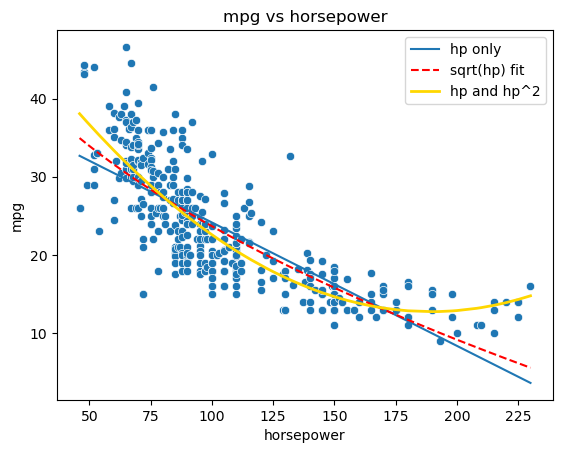

In [42]:
# Run this cell to show the prediction of our model.
predicted_mpg_multi = model_multi.predict(vehicle_data[['horsepower', 'hp^2']])
r2_multi = np.var(predicted_mpg_multi) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_multi)

sns.scatterplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_only, label='hp only');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt, color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_multi, color = 'gold', linewidth=2, label='hp and hp^2');
plt.title("mpg vs horsepower")
plt.legend();

<br><br>

---

### Question 3c

In the cell below, we assign the mean of the `mpg` column of the `vehicle_data` dataframe to `mean_mpg`. Given this information, what is the mean of the `mean_predicted_mpg_hp_only`, `predicted_mpg_hp_sqrt`, and `predicted_mpg_multi` arrays?

**Hint**: Your answer should be a function of `mean_mpg` provided, you should not have to call `np.mean` in your code.


In [43]:
mean_mpg = np.mean(vehicle_data['mpg'])
mean_predicted_mpg_hp_only = mean_mpg
mean_predicted_mpg_hp_sqrt = mean_mpg
mean_predicted_mpg_multi = mean_mpg

In [44]:
grader.check("q3c")

q3c results: All test cases passed!

Comparing this model with previous models:

In [45]:
# Compares q1, q2, q3, and overfit models (ignores redundant model)
print('Multiple R^2 using only horsepower: ', r2_hp_only)
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)
print('Multiple R^2 using both hp and hp^2: ', r2_multi)

Multiple R^2 using only horsepower:  0.605948257889435
Multiple R^2 using sqrt(hp):  0.6437035832706473
Multiple R^2 using both hp and hp^2:  0.6875590305127517


Observed that R^2 value of the last model is the highest. In fact, it can be proven that multiple R^2 will not decrease as we add more more variables. You may be wondering, what will happen if we add more variables? We will discuss limitations of adding too many variables in up coming lecture. Below, we consider an extreme case that we include a variable twice in the model.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

## Faulty Feature Engineering: Redundant Features

Suppose we used the following linear model:

\begin{align}
\text{mpg} &= \theta_0 + \theta_1 \cdot \text{horsepower} + \theta_2 \cdot \text{horsepower}^2 + \theta_3 \cdot \text{horsepower}
\end{align}

Notice that `horsepower` appears twice in our model!! We will explore how this redundant feature affects our modeling.

<br><br>

---

## Question 4

### Question 4a: Linear Algebra

Construct a matrix `X_redundant` that uses the `vehicle_data` DataFrame to encode the "three" features above, as well as a bias feature.

**Hint**: Use the `add_intercept` term you implemented in Question 1a.


In [52]:
X_redundant = add_intercept(vehicle_data[['horsepower', 'hp^2', 'horsepower']])
X_redundant.shape

(392, 4)

In [53]:
grader.check("q4a")

q4a results: All test cases passed!

<br>

Now, run the cell below to find the analytical OLS Estimate using the `get_analytical_sol` function you wrote in Question 1c.

Depending on the machine that you run your code on, you should either see a singular matrix error or end up with thetas that are nonsensical (magnitudes greater than $10^{15}$). This is not good!

In [54]:
# Run this cell to check the result, no further action needed.
# The try-except block suppresses errors during submission
import traceback
try:
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
    analytical_thetas
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/tmp/ipykernel_117/3583356183.py", line 5, in <module>
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
  File "/tmp/ipykernel_117/2089080021.py", line 18, in get_analytical_sol
    return np.linalg.inv(XTX).dot(XTy)
  File "<__array_function__ internals>", line 180, in inv
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 552, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 89, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix



---

### Question 4b

In the cell below, explain why we got the error above when trying to calculate the analytical solution to predict `mpg`.


Since we have the horsepower feature duplicated, we don't have full column rank in X. As result, XˆT * X is not full rank, and we can't invert it. Since we need to invert it as part of the least squares estimate, it fails.

Note: While we encountered errors when using the linear algebra approach, a model fitted with `sklearn` will not encounter matrix singularity errors since it uses numerical methods to find optimums (to be covered in Gradient Descent lecture).

In [57]:
# sklearn finds optimal parameters despite redundant features
model_redundant = LinearRegression(fit_intercept=False) # X_redundant already has an intercept column
model_redundant.fit(X = X_redundant, y = vehicle_data['mpg'])
model_redundant.coef_

array([ 5.69000997e+01, -2.33094815e-01,  1.23053610e-03, -2.33094815e-01])

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Congratulations! You finished the Lab 6!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [58]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q3a results: All test cases passed!

    q3c results: All test cases passed!

    q4a results: All test cases passed!
